In [2]:
import uproot
import glob
import awkward as ak
import numpy as np
import numba as nb
import yaml
import matplotlib.pyplot as plt

### download data

In [3]:
# flist = glob.glob('data/*_batch0.root')
# #flist = glob.glob('/ceph/akhmet/balanced_batches/batch0/*.root')[0:3]

# transformation_dict = yaml.load(open('./transformed_quantities.yml', 'r'), Loader=yaml.FullLoader)

# n_pop_events = 1
# tables = {}

In [4]:
# f = uproot.open('data/electron_absetabin0_ptbin0_batch0.root')
# t = f['taus']
# # t.show() # print tree content

In [5]:
# taus = t.arrays(library='ak')
# tau_i = 7 # random tau index for illustrative purposes
# taus

In [6]:
taus = uproot.concatenate('data/electron_*.root:taus')
tau_i = 7
taus

<Array [{run: 1, lumi: 1004, ... 0]}] type='3075 * {"run": uint32, "lumi": uint3...'>

(array([2802.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         273.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

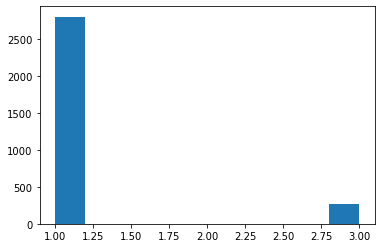

In [7]:
plt.hist(taus['lepton_gen_match'])

### define the grid

In [8]:
inner_cell_size = 0.02
outer_cell_size = 0.05
n_inner_cells = 11
n_outer_cells = 21

In [9]:
inner_grid_size = inner_cell_size * n_inner_cells
inner_grid_left, inner_grid_right = - inner_grid_size / 2, inner_grid_size / 2

outer_grid_size = outer_cell_size * n_outer_cells
outer_grid_left, outer_grid_right = - outer_grid_size / 2, outer_grid_size / 2

### derive constituents' features

In [10]:
constituent_types = ['ele', 'muon', 'pfCand']

In [11]:
# count of constituents for each tau
for c_type in constituent_types: 
    taus[f'n_{c_type}'] = ak.num(taus[f'{c_type}_pt'])

In [12]:
taus[tau_i]['n_ele'],  taus[tau_i]['n_muon'], taus[tau_i]['n_pfCand'],

(1, 0, 54)

In [13]:
# more features here

In [14]:
%%timeit
for c_type in constituent_types: 
    for dim in ['phi', 'eta']:
        taus[f'{c_type}_d{dim}'] = taus[f'{c_type}_{dim}'] - taus[f'tau_{dim}']

13.6 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


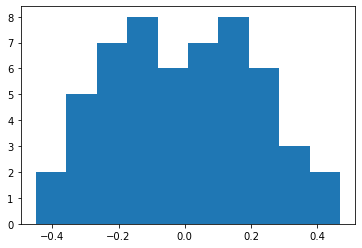

In [15]:
plt.hist(taus[tau_i].pfCand_deta)
plt.show()

### derive inner/outer grid masks

In [16]:
# x = ak.to_numpy(events[0].pfCand_deta)
# np.digitize(x, inner_grid)
# np.searchsorted(inner_grid, x, side='right')

In [17]:
inner_grid_mask_dict = {}
outer_grid_mask_dict = {}

In [18]:
%%timeit
for c_type in constituent_types:
    inner_grid_eta_mask = (taus[f'{c_type}_deta'] > inner_grid_left) & (taus[f'{c_type}_deta'] < inner_grid_right)
    inner_grid_phi_mask = (taus[f'{c_type}_dphi'] > inner_grid_left) & (taus[f'{c_type}_dphi'] < inner_grid_right)
    inner_grid_mask = inner_grid_eta_mask * inner_grid_phi_mask
    
    outer_grid_eta_mask = (taus[f'{c_type}_deta'] > outer_grid_left) & (taus[f'{c_type}_deta'] < outer_grid_right) & ~inner_grid_eta_mask
    outer_grid_phi_mask = (taus[f'{c_type}_dphi'] > outer_grid_left) & (taus[f'{c_type}_dphi'] < outer_grid_right) & ~inner_grid_phi_mask
    outer_grid_mask = outer_grid_eta_mask * outer_grid_phi_mask

    inner_grid_mask_dict[c_type] = inner_grid_mask
    outer_grid_mask_dict[c_type] = outer_grid_mask

28.3 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
outer_grid_mask_dict

{'ele': <Array [[False], [False], ... [False], [False]] type='3075 * var * bool'>,
 'muon': <Array [[], [], [], [], ... [], [], [], []] type='3075 * var * bool'>,
 'pfCand': <Array [[True, False, True, ... False, False]] type='3075 * var * bool'>}

In [20]:
for c_type in constituent_types:  
    print(f'{c_type}: total {sum(inner_grid_mask_dict[c_type][tau_i])} constituents in the inner cone for tau with i={tau_i}')
    print(f'{c_type}: total {sum(outer_grid_mask_dict[c_type][tau_i])} constituents in the outer cone for tau with i={tau_i}')
    print()

ele: total 1 constituents in the inner cone for tau with i=7
ele: total 0 constituents in the outer cone for tau with i=7

muon: total 0 constituents in the inner cone for tau with i=7
muon: total 0 constituents in the outer cone for tau with i=7

pfCand: total 3 constituents in the inner cone for tau with i=7
pfCand: total 24 constituents in the outer cone for tau with i=7



In [21]:
for c_type in constituent_types: 
    print(15*'*')
    print()
    print(f'{c_type}: total count of constituents per tau in the inner cone\n{ak.sum(inner_grid_mask_dict[c_type], axis=1)}')
    print()
    print(f'{c_type}: total count of constituents per tau in the outer cone\n{ak.sum(outer_grid_mask_dict[c_type], axis=1)}')
    print()
print(15*'*')

***************

ele: total count of constituents per tau in the inner cone
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

ele: total count of constituents per tau in the outer cone
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

***************

muon: total count of constituents per tau in the inner cone
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

muon: total count of constituents per tau in the outer cone
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

***************

pfCand: total count of constituents per tau in the inner cone
[3, 6, 2, 4, 7, 2, 4, 3, 6, 4, 7, 4, 7, 3, ... 1, 5, 7, 1, 3, 6, 6, 5, 6, 8, 3, 4, 9]

pfCand: total count of constituents per tau in the outer cone
[21, 25, 20, 34, 22, 42, 31, 24, 29, 26, ... 26, 23, 32, 38, 33, 37, 29, 24, 33, 30]

***************


### derive cell indices 

In [22]:
%%timeit
for c_type in constituent_types: 
    # get grid indices by affine transforming the grid to an array of grid indices (that is, np.arange(n_inner_cells)), and then flooring to the nearest integer  
    inner_grid_eta_ids = np.floor((taus[f'{c_type}_deta'] - inner_grid_left) / inner_grid_size * n_inner_cells) 
    inner_grid_phi_ids = np.floor((taus[f'{c_type}_dphi'] - inner_grid_left) / inner_grid_size * n_inner_cells)
    outer_grid_eta_ids = np.floor((taus[f'{c_type}_deta'] - outer_grid_left) / outer_grid_size * n_outer_cells) 
    outer_grid_phi_ids = np.floor((taus[f'{c_type}_dphi'] - outer_grid_left) / outer_grid_size * n_outer_cells)

    # add for each tau two branches (one for inner and one for outer grid) which store for each constituent a tuple: 
    # tuple: (index in constituent list, eta index on grid, phi index on grid)
    inner_grid_ids = ak.zip([ak.local_index(inner_grid_eta_ids, axis=1), inner_grid_eta_ids, inner_grid_phi_ids])
    outer_grid_ids = ak.zip([ak.local_index(outer_grid_eta_ids, axis=1), outer_grid_eta_ids, outer_grid_phi_ids])

    # mask with None those consituents which don't belong to the corresponding grid
    inner_grid_ids = ak.mask(inner_grid_ids, inner_grid_mask_dict[c_type]) 
    outer_grid_ids = ak.mask(outer_grid_ids, outer_grid_mask_dict[c_type])
    
    # # additionally, can fill Nones with some values
    # inner_grid_ids = ak.fill_none(inner_grid_ids, -1) 
    # outer_grid_ids = ak.fill_none(outer_grid_ids, -1) 

    taus[f'inner_grid_{c_type}_indices'] = inner_grid_ids
    taus[f'outer_grid_{c_type}_indices'] = outer_grid_ids

36.7 ms ± 663 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
for c_type in constituent_types: 
    print(15*'*')
    print()
    print(f'{c_type}: indices of constituents for tau with i={tau_i} in the inner cone\n{taus[f"inner_grid_{c_type}_indices"][inner_grid_mask_dict[c_type]][tau_i]}')
    print()
    print(f'{c_type}: indices of constituents for tau with i={tau_i} in the outer cone\n{taus[f"outer_grid_{c_type}_indices"][outer_grid_mask_dict[c_type]][tau_i]}')
    print()
print(15*'*')

***************

ele: indices of constituents for tau with i=7 in the inner cone
[(0, 5, 5)]

ele: indices of constituents for tau with i=7 in the outer cone
[]

***************

muon: indices of constituents for tau with i=7 in the inner cone
[]

muon: indices of constituents for tau with i=7 in the outer cone
[]

***************

pfCand: indices of constituents for tau with i=7 in the inner cone
[(9, 7, 5), (21, 5, 5), (36, 7, 9)]

pfCand: indices of constituents for tau with i=7 in the outer cone
[(0, 14, 5), (1, 14, 4), (4, 7, 2), (7, 4, 7), ... 17, 6), (50, 13, 3), (53, 3, 5)]

***************


In [24]:
const_i = taus['inner_grid_pfCand_indices'][inner_grid_mask_dict['pfCand']][tau_i][0]
const_i = ak.to_list(const_i)
const_i

(9, 7.0, 5.0)

In [25]:
taus[tau_i]['pfCand_pt'][const_i[0]]

0.72021484375

### create grid matrices

In [26]:
# haven't come up yet with smth w/o loops over tau
# on the other hand, it seems to be very memory (and time) consuming to store such sparse tensors
# storing just indices and using them downstream looks like a better approach

In [27]:
%%timeit
inner_grids = []
c_type = 'pfCand'
for i, tau_ in enumerate(taus):
    inner_grid_ = np.zeros((taus[i][f'n_{c_type}'], n_inner_cells, n_inner_cells))
    inner_grid_id_ = ak.to_list(taus[f'inner_grid_{c_type}_indices'][inner_grid_mask_dict[c_type]][i])
    np.put(inner_grid_, inner_grid_id_, 1)
    inner_grids.append(inner_grid_)
taus['inner_grid_pfCand'] = inner_grids

11.4 s ± 769 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
len(taus)

3075

### trying numba

In [29]:
@nb.jit
def get_inner_grids(c_type):
    inner_grids = np.empty((len(taus)))
    for i, tau_ in enumerate(taus):
        inner_grids[i]  = np.zeros((taus[i][f'n_{c_type}'], n_inner_cells, n_inner_cells))
#         inner_grid_id_ = ak.to_list(taus[f'inner_grid_{c_type}_indices'][inner_grid_mask_dict[c_type]][i])
#         np.put(inner_grid_, inner_grid_id_, 1)
#         inner_grids[i] = inner_grid_
    return inner_grids

In [30]:
%%timeit
taus['inner_grid_pfCand'] = get_inner_grids('pfCand')

UnsupportedError: Failed in object mode pipeline (step: analyzing bytecode)
Use of unsupported opcode (FORMAT_VALUE) found

File "<ipython-input-29-eaebfe530a39>", line 5:
def get_inner_grids(c_type):
    <source elided>
    for i, tau_ in enumerate(taus):
        inner_grids[i]  = np.zeros((taus[i][f'n_{c_type}'], n_inner_cells, n_inner_cells))
        ^


### misc.

In [37]:
np.meshgrid(inner_grid_eta_ids[0], inner_grid_phi_ids[0])

TypeError: no implementation found for 'numpy.meshgrid' on types that implement __array_function__: [<class 'awkward.highlevel.Array'>]

In [26]:
inner_grid_eta_ids[0][np.newaxis, :]

<Array [... 0, 0, 10, 6, 2, 0, 0, 0, 0, 0]] type='1 * 56 * float64'>

In [31]:
ak.broadcast_arrays(inner_grid_eta_ids[0], inner_grid_eta_ids[0][np.newaxis, :])

[<Array [... 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 0]] type='1 * 56 * float64'>,
 <Array [... 0, 0, 10, 6, 2, 0, 0, 0, 0, 0]] type='1 * 56 * float64'>]

In [57]:
np.outer(ak.to_numpy(inner_grid_eta_ids[0]), ak.to_numpy(inner_grid_phi_ids[0]))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])